In [1]:
import logging
import sys


date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

# Data

### Training data
- Source: http://mattmahoney.net/dc/text8.zip
- Stored in: `data/train.txt`

### Analogies data
- Source: https://raw.githubusercontent.com/nicholas-leonard/word2vec/refs/heads/master/questions-words.txt
- Stored in: `data/analogies.txt`

# Defining model

In [2]:
from scipy.spatial import distance

def evaluate_analogy(model, word_tuple):
    w0_embedding = model.wv[word_tuple[0]]
    w1_embedding = model.wv[word_tuple[1]]
    w2_embedding = model.wv[word_tuple[2]]
    w3_embedding = model.wv[word_tuple[3]]

    return distance.cosine(
        w1_embedding - w0_embedding,
        w3_embedding - w2_embedding,
    )


In [3]:
analogies_file_name = "../data/analogies.txt"

with open(analogies_file_name) as file:
    file_content = file.read().splitlines()

analogies = {}
last_key_added = None
for line in file_content:
    if line[0] == ":":
        last_key_added = line.replace(": ", "")
        analogies[last_key_added] = []

    else:
        analogies[last_key_added].append(
            line.lower().split(" ")
        )

analogies[last_key_added][:3]

[['decrease', 'decreases', 'describe', 'describes'],
 ['decrease', 'decreases', 'eat', 'eats'],
 ['decrease', 'decreases', 'enhance', 'enhances']]

In [4]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec


loss_curve = []

class EpochLogger(CallbackAny2Vec):
    def __init__(self, losses_array):
        self.epoch = 0
        self.losses_array = losses_array

    def on_epoch_begin(self, model):
        print(f"Epoch #{self.epoch} start")

    def on_epoch_end(self, model):
        self.losses_array.append(model.get_latest_training_loss())

        print(
            f"Epoch #{self.epoch} end.\nTraining loss: {model.get_latest_training_loss()}"
        )
        self.epoch += 1

word_embedder = Word2Vec(
    compute_loss=True,
    corpus_file="../data/train.txt",
    sg=1,
    window=9,
    vector_size=100,
    epochs=10,
    min_count=0,
    callbacks=[EpochLogger(losses_array=loss_curve)]
)


2024-12-24 12:21:51 collecting all words and their counts
2024-12-24 12:21:52 PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-12-24 12:21:56 collected 253854 word types from a corpus of 17005207 raw words and 1701 sentences
2024-12-24 12:21:56 Creating a fresh vocabulary
2024-12-24 12:21:56 Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 253854 unique words (100.00% of original 253854, drops 0)', 'datetime': '2024-12-01T12:21:56.904023', 'gensim': '4.3.3', 'python': '3.10.14 (main, Apr 15 2024, 18:28:39) [Clang 17.0.6 ]', 'platform': 'Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}
2024-12-24 12:21:56 Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 17005207 word corpus (100.00% of original 17005207, drops 0)', 'datetime': '2024-12-01T12:21:56.905397', 'gensim': '4.3.3', 'python': '3.10.14 (main, Apr 15 2024, 18:28:39) [Clang 17.0.6 ]', 'platform': 'Linux-5.15.153.1-microsoft-standard-WSL2-x

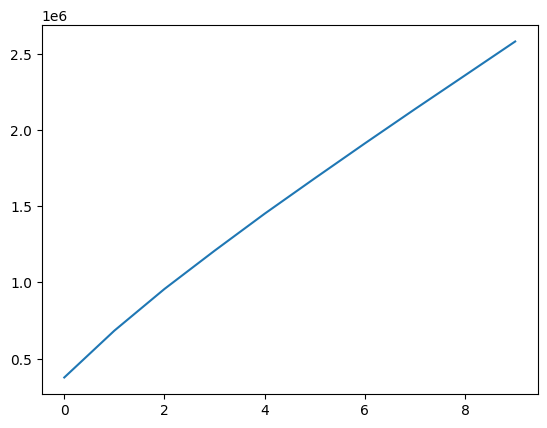

In [5]:
import matplotlib.pyplot as plt

plt.plot(loss_curve)
plt.show()

In [6]:
import numpy as np

report = {k: 0.0 for k in analogies.keys()}
for sub_category in report.keys():
    report[sub_category] = np.average(
        [
            evaluate_analogy(word_embedder, curr_sample) for curr_sample in analogies[sub_category]
            if all([word_embedder.wv.__contains__(sample) for sample in curr_sample])
        ]
    )

report["overall_average"] = np.average(list(report.values()))
report

{'capital-common-countries': 0.8313870096412811,
 'capital-world': 0.9775351842601802,
 'currency': 0.9472992574106125,
 'city-in-state': 0.8127554966517218,
 'family': 0.8568015671698033,
 'gram1-adjective-to-adverb': 0.9766127064953365,
 'gram2-opposite': 0.8496774422774573,
 'gram3-comparative': 0.8186714838002181,
 'gram4-superlative': 0.6342162429427117,
 'gram5-present-participle': 0.9596752007156611,
 'gram6-nationality-adjective': 0.9999506674276156,
 'gram7-past-tense': 0.9879978406432277,
 'gram8-plural': 0.9253952315140421,
 'gram9-plural-verbs': 0.815993753776183,
 'overall_average': 0.8852835060518609}